In [339]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.common.by import By
import warnings

## Create Driver

In [ ]:
driver = webdriver.Firefox(service=FirefoxService(GeckoDriverManager().install()))

## Scrape characters

In [ ]:
sourse_url = "https://iceandfire.fandom.com/wiki/Category:Characters"

letters_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N",
                "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

characters = []

for letter in letters_list:
    
    # go through each letter
    page_url = sourse_url + "?from=" + letter
    driver.get(page_url)
    character_elems = driver.find_elements(by=By.CLASS_NAME, value = 'category-page__member-link')
    
    # collect all character names and urls
    for character in character_elems:
        character_url = character.get_attribute('href')
        character_name = character.text
        characters.append({'character_name': character_name, "url": character_url})
    

## Scrape characters' info

In [ ]:
# collect info for all characters

character_list = []
books_list = ["A Game of Thrones", "A Clash of Kings", "A Storm of Swords", "A Feast for Crows", 
              "A Dance with Dragons", "The Winds of Winter"]

for character in characters:
        
    # go to character page
    driver.get(character['url'])
    
    # extract alias info
    alias = driver.find_elements(By.XPATH,'//div[@class="pi-item pi-data pi-item-spacing pi-border-color" and @data-source="alias"]')
    try:
        alias = alias[0].text[6:].replace('\n', ', ')
    except:
        alias = ""
    
    # extract allegiance info
    allegiance = driver.find_elements(By.XPATH,'//div[@class="pi-item pi-data pi-item-spacing pi-border-color" and @data-source="allegiance"]')
    try:
        allegiance = allegiance[0].text[11:].replace('\n', ', ')
    except:
        allegiance = ""
    
    # extract culture info
    culture = driver.find_elements(By.XPATH, '//div[@class="pi-item pi-data pi-item-spacing pi-border-color" and @data-source="culture"]')
    try:
        culture = culture[0].text[8:].replace('\n', ', ')
    except:
        culture = ""
    
    # extract books info
    books = driver.find_elements(By.XPATH, '//div[@class="pi-item pi-data pi-item-spacing pi-border-color" and @data-source="books"]')
    try:
        books = books[0].text[6:].replace('\n', ', ')
    except:
        books = ""
    
    if books == "":
        titles = driver.find_elements(By.TAG_NAME, "h3")
        book_list = []
        for title in titles:
            for book in books_list:
                if book in title.text:
                    book_list.append(book)
        if bool(len(book_list)):
            books = ', '.join(book_list)
        else:
            books = ""
        
    # add info to character list
    character_list.append({'character_name':character['character_name'], 'alias': alias, "allegiance": allegiance, "culture": culture, "books": books})
    

## Turn list into a data frame

In [ ]:
characters_df = pd.DataFrame(character_list)

In [285]:
characters_df.head()

,Unnamed: 0.1,character_name,alias,allegiance,culture,books
0,0,Addam Marbrand,Unknown,"House Marbrand, House Lannister, City Watch",Andals,A Feast for Crows
1,2,Adrack Humble,Unknown,"House Humble, House Greyjoy",Ironborn,A Dance with Dragons
2,5,Aegon Frey,Unknown,"House Frey, House Tully",Riverlands,"A Game of Thrones, A Clash of Kings, A Storm o..."
3,7,Aegon I Targaryen,"Aegon the Conqueror, Aegon the Dragonlord, Aeg...",House Targaryen,Valyrian,"A Game of Thrones, A Clash of Kings, A Storm o..."
6,20,Aemon (wildling),Unknown,Unknown,Unknown,A Feast for Crows


In [250]:
# save the data frame
characters_df.to_csv('characters.csv')

## Clean the data frame

In [590]:
# import saved data frame
characters_df = pd.read_csv('characters.csv')

In [591]:
# general cleaning

# remove unused column
characters_df = characters_df.drop('Unnamed: 0.1', axis=1)

# remove characters that don't appear in any books
characters_df = characters_df[characters_df['books'].notnull()]

# delete rows with empty strings
characters_df = characters_df[characters_df['books'] != ""]


In [592]:
# clean the books column

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # delete all explanatory notes in brackets
    characters_df["books"] = characters_df["books"].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x))

    # delete books that are not in Song of Ice and Fire series
    books_to_delete = ["The World of Ice & Fire", "Fire & Blood", "The Princess and the Queen", "The Hedge Knight", "The Sworn Sword", 
                       "The Mystery Knight", "The Rogue Prince", "The Sons of the Dragon", "The World of Ice and Fire", 
                       "A World of Ice & Fire", "Ice and Fire", "Fire and Blood", "The Rouge Prince"]

    pattern = '|'.join(books_to_delete)
    characters_df["books"] = characters_df["books"].str.replace(pattern, '')

    # delete commas in the beginning of a string
    characters_df["books"] = characters_df["books"].str.replace("^[,\s]*", "")

    # delete excessive commas inside a string
    characters_df["books"] = characters_df["books"].str.replace(" , ", "")
    characters_df["books"] = characters_df["books"].str.replace(", ", ",")


    # insert missing commas
    characters_df["books"] = characters_df["books"].str.replace("A Clash of Kings, A Storm of SwordsA Feast for Crows", "A Clash of Kings, A Storm of Swords, A Feast for Crows")
    characters_df["books"] = characters_df["books"].str.replace("A Clash of Kings, A Storm of SwordsA Feast for CrowsA Dance with Dragons", "A Clash of Kings, A Storm of Swords, A Feast for Crows, A Dance with Dragons")
    characters_df["books"] = characters_df["books"].str.replace("A Clash of Kings, A Storm of Swords, A Feast for CrowsA Dance with Dragons", "A Clash of Kings, A Storm of Swords, A Feast for Crows, A Dance with Dragons")
    
    # correct typos
    characters_df["books"] = characters_df["books"].str.replace("A Storm of Swords", "A Storm of Sword")


In [593]:
# clean the aliases column

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # replace nan with Unknown
    characters_df = characters_df.fillna("Unknown")
    
    # delete references
    characters_df["alias"] = characters_df["alias"].str.replace(r'\[\d+\]', '')
    
    # delete spaces after comma
    characters_df["alias"] = characters_df["alias"].str.replace(", ", ",")

In [594]:
# clean the allegiance column

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # delete all explanatory notes in brackets
    characters_df["allegiance"] = characters_df["allegiance"].apply(lambda x: x if pd.isna(x) or not isinstance(x, str) else re.sub(r'\s*\([^)]*\)', '', x))
    
    # delete spaces after comma
    characters_df["allegiance"] = characters_df["allegiance"].str.replace(", ", ",")
    
    # delete double commas
    characters_df["allegiance"] = characters_df["allegiance"].str.replace(",,", ",")
    

In [595]:
# clean the culture column

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # delete westeros repetitions
    characters_df["culture"] = characters_df["culture"].str.replace('Westeros, ', '')
    
    # delete additional info
    characters_df["culture"] = characters_df["culture"].str.replace(', With influence from the Andals', '')
    characters_df["culture"] = characters_df["culture"].str.replace(', With influence from the Andals and the Northmen', '')
    characters_df["culture"] = characters_df["culture"].str.replace(', With influence from the Andals and the Free Cities', '')
    characters_df["culture"] = characters_df["culture"].str.replace(', With influence from the Free Cities and the Andals', '')

    # correct different instances of one name
    characters_df["culture"] = characters_df["culture"].str.replace('/', ', ')
    characters_df["culture"] = characters_df["culture"].str.replace('Northman', 'Northmen')
    characters_df["culture"] = characters_df["culture"].str.replace('Dornishman', 'Dornish')
    characters_df["culture"] = characters_df["culture"].str.replace('Dornishmen', 'Dornish')
    characters_df["culture"] = characters_df["culture"].str.replace('Free folk', 'Free Folk')
    characters_df["culture"] = characters_df["culture"].str.replace('Reachman', 'Reach')
    characters_df["culture"] = characters_df["culture"].str.replace('Reachmen', 'Reach')
    characters_df["culture"] = characters_df["culture"].str.replace('Riverlander', 'Riverlands')
    characters_df["culture"] = characters_df["culture"].str.replace('Riverman', 'Riverlands')
    characters_df["culture"] = characters_df["culture"].str.replace('Rivermen', 'Riverlands')
    characters_df["culture"] = characters_df["culture"].str.replace('The Westerlands', 'Westerlands')
    characters_df["culture"] = characters_df["culture"].str.replace('Westerlander', 'Westerlands')
    characters_df["culture"] = characters_df["culture"].str.replace('Westerman', 'Westerlands')
    characters_df["culture"] = characters_df["culture"].str.replace('Westermen', 'Westerlands')
    characters_df["culture"] = characters_df["culture"].str.replace('Westeros', 'Westerlands')
    characters_df["culture"] = characters_df["culture"].str.replace('Westman', 'Westerlands')
    characters_df["culture"] = characters_df["culture"].str.replace('Valyrians', 'Valyrian')
    characters_df["culture"] = characters_df["culture"].str.replace('Valemen', 'Vale of Arryn')
    characters_df["culture"] = characters_df["culture"].str.replace('Wildlings', 'Wildling')
    characters_df["culture"] = characters_df["culture"].str.replace(' and the ', ',')


## Preliminary Analysis

### Characters by books

In [596]:
# Divide the values in column by comma
characters_df['books'] = characters_df['books'].str.split(',')

In [597]:
# Create a new DataFrame to store the separated values
books_df = pd.DataFrame(columns=['book', 'character_name'])

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # Iterate over the rows of the original DataFrame
    for _, row in characters_df.iterrows():
        # Iterate over the list of separated values
        for value in row['books']:
            # Append a new row to the new DataFrame
            books_df = books_df.append({'book': value.strip(), 'character_name': row['character_name']}, ignore_index=True)

In [598]:
# Group by books and count
df_grouped_books = books_df.groupby("book")["character_name"].count().sort_values(ascending=False).reset_index(name='character_counts')
df_grouped_books

,book,character_counts
0,A Feast for Crows,351
1,A Storm of Sword,261
2,A Game of Thrones,249
3,A Clash of Kings,239
4,A Dance with Dragons,219
5,The Winds of Winter,39


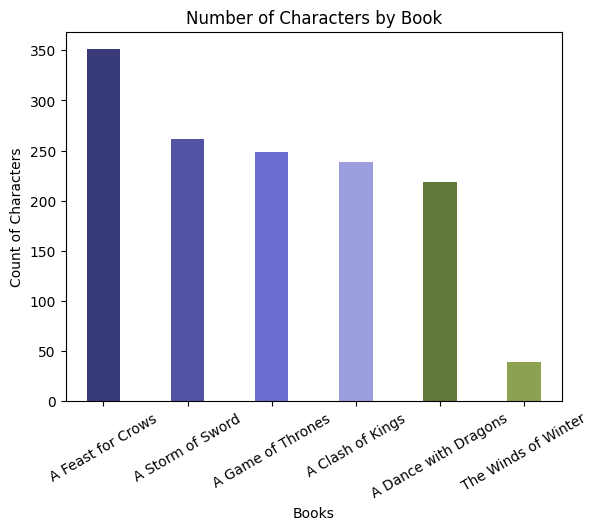

In [599]:
# Plot number of characters grouped by books
colors=plt.get_cmap('tab20b').colors
ax = df_grouped_books.plot(x='book', y='character_counts', kind='bar', color=colors, width=0.4)
ax.set_ylabel('Count of Characters')
ax.set_xlabel('Books')
ax.set_title('Number of Characters by Book')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

###  Characters by cultures

In [600]:
# Divide the values in column by comma
characters_df['culture'] = characters_df['culture'].str.split(',')

In [601]:
# Create a new DataFrame to store the separated values
culture_df = pd.DataFrame(columns=['culture', 'character_name'])

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # Iterate over the rows of the original DataFrame
    for _, row in characters_df.iterrows():
        # Iterate over the list of separated values
        for value in row['culture']:
            # Append a new row to the new DataFrame
            culture_df = culture_df.append({'culture': value.strip(), 'character_name': row['character_name']}, ignore_index=True)

In [602]:
# Group by cultures and count
df_grouped_cul = culture_df.groupby("culture")["character_name"].count().sort_values(ascending=False).reset_index(name='character_counts')
df_grouped_cul = df_grouped_cul[df_grouped_cul["culture"] != "Unknown"]
df_grouped_cul.head()

,culture,character_counts
1,Ironborn,73
2,Northmen,65
3,Andals,55
4,Riverlands,54
5,Westerlands,14


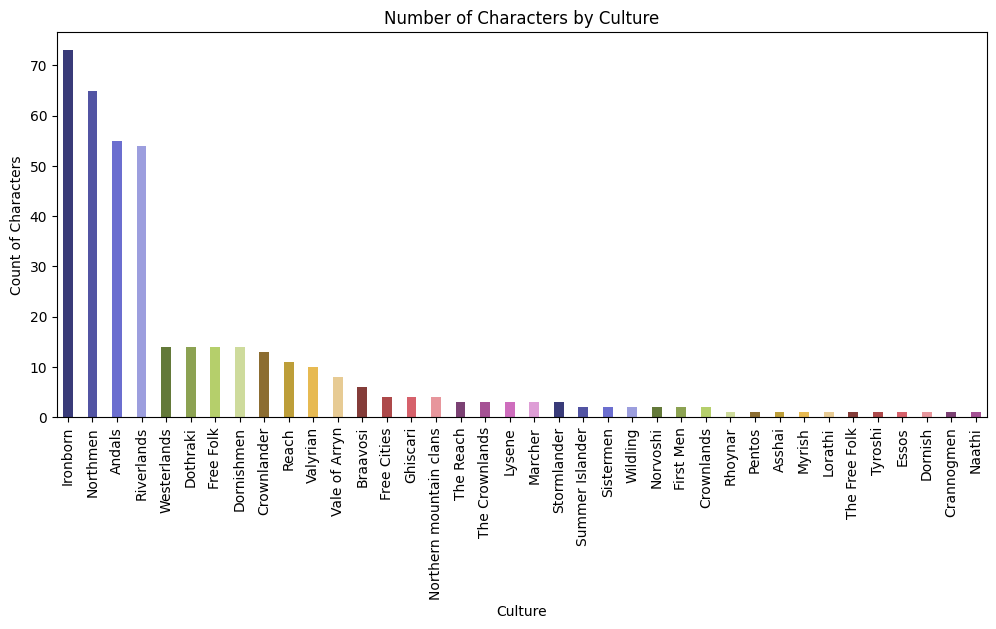

In [603]:
# Plot number of characters grouped by cultures
colors=plt.get_cmap('tab20b').colors
fig = plt.figure(figsize=(12, 5))
ax = df_grouped_cul.plot(x='culture', y='character_counts', kind='bar', color=colors, width=0.4, ax=fig.gca())
ax.set_ylabel('Count of Characters')
ax.set_xlabel('Culture')
ax.set_title('Number of Characters by Culture')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

## Save cleaned data frame

In [609]:
# save the data frame
characters_df.to_csv('characters_cleaned.csv')